In [1]:
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose, BatchNormalization
from keras.models import Model
from keras.datasets import cifar10
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
from keras.callbacks import CSVLogger

import numpy as np
import matplotlib.pyplot as plt
import argparse

Using TensorFlow backend.
C:\Conda\envs\Tensorflow-GPU\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Conda\envs\Tensorflow-GPU\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Conda\envs\Tensorflow-GPU\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Conda\envs\Tensorflow-GPU\lib\site-packages\tensorflow\python\fra

In [2]:
# dimension of the latent space (min 2)
latent_dim = 512

# CIFAR dataset

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# choose one of them
my_class = 7

# parameters, we will use it later
# 32
image_size = x_train.shape[1]
# 32x32x3
input_shape = (image_size, image_size, 3)

# Normalization of pixel values (to [0-1] range)
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

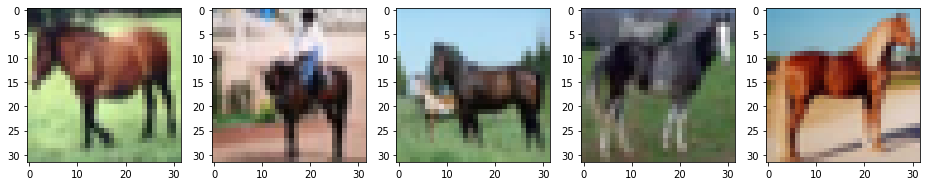

In [4]:
# select images of one class
number_of_images = 5000
n = 0
i = 0
x_in = np.zeros((number_of_images,image_size,image_size,3))

for y in y_train:
    if (y == my_class and n != number_of_images-1):
        x_in[n]=(x_train[i])
        n += 1
    i += 1 
    
# and show some of them
f, axarr = plt.subplots(1, 5)
f.set_size_inches(16, 6)
for i in range(5):
    img = x_in[i]
    axarr[i].imshow(img)
plt.show()

# VAE MODEL

## ENCODER

In [5]:
# reparameterization trick
# z = mean + sqrt(var)*eps
# where only eps is random, we can backprop on the other parameters
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [6]:
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
x = Conv2D(filters=32, kernel_size=3, activation='relu', strides=2, padding='same')(x)
x = Conv2D(filters=64, kernel_size=2, activation='relu', strides=2, padding='same')(x)
x = Conv2D(filters=128, kernel_size=3, activation='relu', strides=2, padding='same')(x)     
x = Conv2D(filters=256, kernel_size=3, activation='relu', strides=2, padding='same')(x)   

# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(latent_dim*2, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 32)   896         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 8, 8, 64)     8256        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 4, 4, 128)    73856       conv2d_2[0][0]                   
_____________________________________

## DECODER

In [7]:
# input = z latent space
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

x = Conv2DTranspose(filters=256, kernel_size=5, activation='relu', strides=2, padding='same')(x)
x = BatchNormalization(momentum=0.9)(x)
x = Conv2DTranspose(filters=128, kernel_size=5, activation='relu', strides=2, padding='same')(x)
x = BatchNormalization(momentum=0.9)(x)
x = Conv2DTranspose(filters=64, kernel_size=3, activation='relu', strides=2, padding='same')(x)
x = BatchNormalization(momentum=0.9)(x)
x = Conv2DTranspose(filters=32, kernel_size=2, activation='relu', strides=2, padding='same')(x)
x = BatchNormalization(momentum=0.9)(x)
outputs = Conv2DTranspose(filters=3, kernel_size=2, activation='sigmoid', padding='same', name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
reshape_1 (Reshape)          (None, 2, 2, 256)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 4, 4, 256)         1638656   
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 256)         1024      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 8, 8, 128)         819328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 128)         512       
__________

## VAE

In [8]:
# out = D(E(x))
# where E(x)=z
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

In [9]:
# VAE loss = xent_loss + kl_loss
reconstruction_loss = binary_crossentropy(K.flatten(inputs),K.flatten(outputs))
reconstruction_loss *= image_size * image_size
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

In [10]:
# compile VAE with loss
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 32, 32, 3)         0         
_________________________________________________________________
encoder (Model)              [(None, 512), (None, 512) 2477376   
_________________________________________________________________
decoder (Model)              (None, 32, 32, 3)         3067619   
Total params: 5,544,995
Trainable params: 5,544,035
Non-trainable params: 960
_________________________________________________________________


# TRAIN

In [11]:
# logger
csv_logger = CSVLogger('VAElog.csv', append=True, separator=';')
# train parameters
batch_size = 256
epochs = 100

vae.fit(x_in, epochs=epochs, batch_size=batch_size, validation_data=(x_in, None), callbacks=[csv_logger])
vae.save_weights('vae_cnn_cifar.h5')

Instructions for updating:
Use tf.cast instead.
Train on 5000 samples, validate on 5000 samples
Epoch 1/100
5000/5000 [==============================] - 28s 6ms/step - loss: 735.2452 - val_loss: 714.7496
Epoch 2/100
5000/5000 [==============================] - 19s 4ms/step - loss: 703.2749 - val_loss: 702.5071
Epoch 3/100
5000/5000 [==============================] - 19s 4ms/step - loss: 701.8403 - val_loss: 701.6948
Epoch 4/100
5000/5000 [==============================] - 19s 4ms/step - loss: 701.2043 - val_loss: 700.1525
Epoch 5/100
5000/5000 [==============================] - 19s 4ms/step - loss: 697.0998 - val_loss: 694.7660
Epoch 6/100
5000/5000 [==============================] - 19s 4ms/step - loss: 691.2811 - val_loss: 687.2207
Epoch 7/100
5000/5000 [==============================] - 19s 4ms/step - loss: 684.0740 - val_loss: 681.8718
Epoch 8/100
5000/5000 [==============================] - 19s 4ms/step - loss: 676.3881 - val_loss: 675.0659
Epoch 9/100
5000/5000 [=================

5000/5000 [==============================] - 19s 4ms/step - loss: 642.0016 - val_loss: 642.3025
Epoch 74/100
5000/5000 [==============================] - 19s 4ms/step - loss: 641.8143 - val_loss: 641.7268
Epoch 75/100
5000/5000 [==============================] - 19s 4ms/step - loss: 641.8226 - val_loss: 641.9989
Epoch 76/100
5000/5000 [==============================] - 19s 4ms/step - loss: 641.7722 - val_loss: 641.9692
Epoch 77/100
5000/5000 [==============================] - 19s 4ms/step - loss: 641.3654 - val_loss: 641.6090
Epoch 78/100
5000/5000 [==============================] - 19s 4ms/step - loss: 641.7770 - val_loss: 641.4130
Epoch 79/100
5000/5000 [==============================] - 19s 4ms/step - loss: 641.5194 - val_loss: 641.1548
Epoch 80/100
5000/5000 [==============================] - 19s 4ms/step - loss: 641.0064 - val_loss: 640.6404
Epoch 81/100
5000/5000 [==============================] - 19s 4ms/step - loss: 640.9295 - val_loss: 641.8581
Epoch 82/100
5000/5000 [========

# PLOT

In [12]:
def plot_results(encoder, decoder, x_test, y_test, batch_size=128, model_name="vae_cifar"):
    
    # display a nxn 2D manifold of images
    n = 10
    img_size = 32
    figure = np.zeros((img_size * n, img_size * n,3))
    # linearly spaced coordinates corresponding to the 2D plot
    grid_x = np.linspace(-1, 1, n)
    grid_y = np.linspace(-1, 1, n)[::-1]

  # display a 2D plot of the image classes in the first 2 dimensions of the latent space 
    #to see if the latent
    z_mean, _, _ = encoder.predict(x_test, batch_size=batch_size)
    plt.figure(figsize=(n, n))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

  # display the generated images along the first 2 dimensions of the latent space
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.random.normal(0.0, 1.0, (1,latent_dim))
            # the first two dim is given
            z_sample[0,0]=xi
            z_sample[0,1]=yi
            # generate an image from the latent representation
            x_decoded = decoder.predict(z_sample)
            img = x_decoded[0].reshape(img_size, img_size, 3)
            figure[i * img_size: (i + 1) * img_size,
                   j * img_size: (j + 1) * img_size,] = img

    plt.figure(figsize=(20, 20))
    start_range = img_size // 2
    end_range = n * img_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, img_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.show()



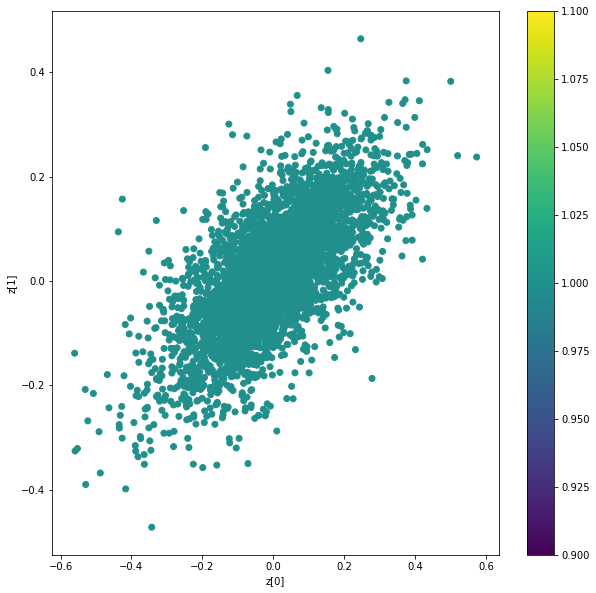

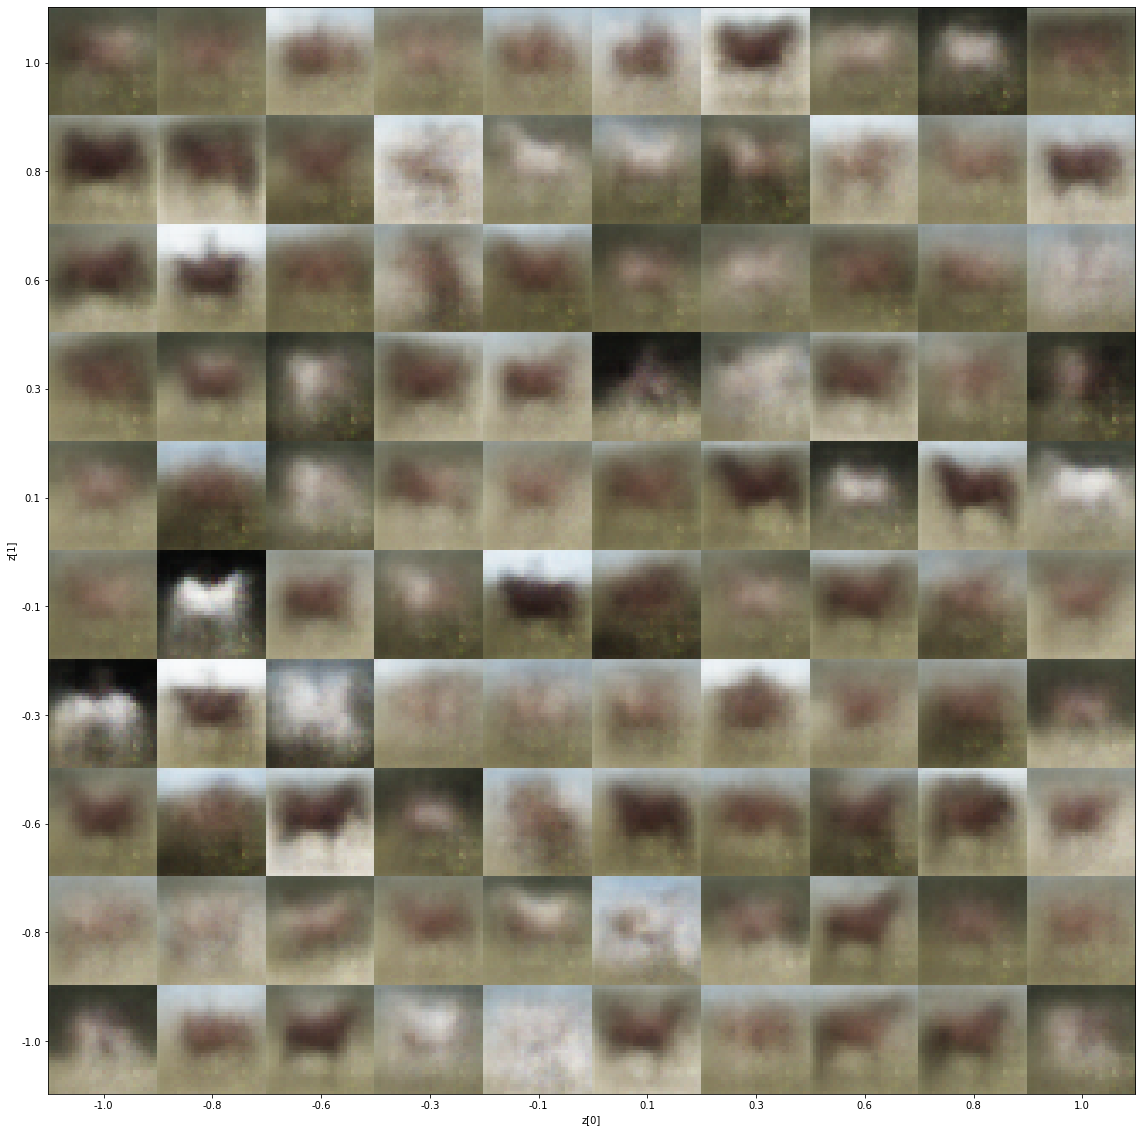

In [13]:
# now we have only one class
plot_results(encoder, decoder, x_in, np.ones((x_in.shape[0])), batch_size=batch_size, model_name="vae_cnn")